In [2]:


# Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [3]:
# Load captions
captions_file = r'D:\ImageCaptioning\data\raw\Flickr8k_text\Flickr8k.token.txt'
with open(captions_file, 'r') as file:
    captions = file.readlines()

# Load images
image_dir = r'D:\ImageCaptioning\data\raw\Flickr8k_Dataset\Flicker8k_Dataset'
image_files = os.listdir(image_dir)

# Function to extract captions from file
def extract_captions(captions):
    caption_dict = {}
    for line in captions:
        parts = line.strip().split('\t')
        image_id = parts[0].split('#')[0]
        caption = parts[1]
        if image_id not in caption_dict:
            caption_dict[image_id] = []
        caption_dict[image_id].append(caption)
    return caption_dict

# Extract captions from file
caption_dict = extract_captions(captions)

# Display number of unique images and captions
print("Number of unique images:", len(caption_dict))
print("Number of total captions:", sum(len(captions) for captions in caption_dict.values()))


Number of unique images: 8092
Number of total captions: 40460


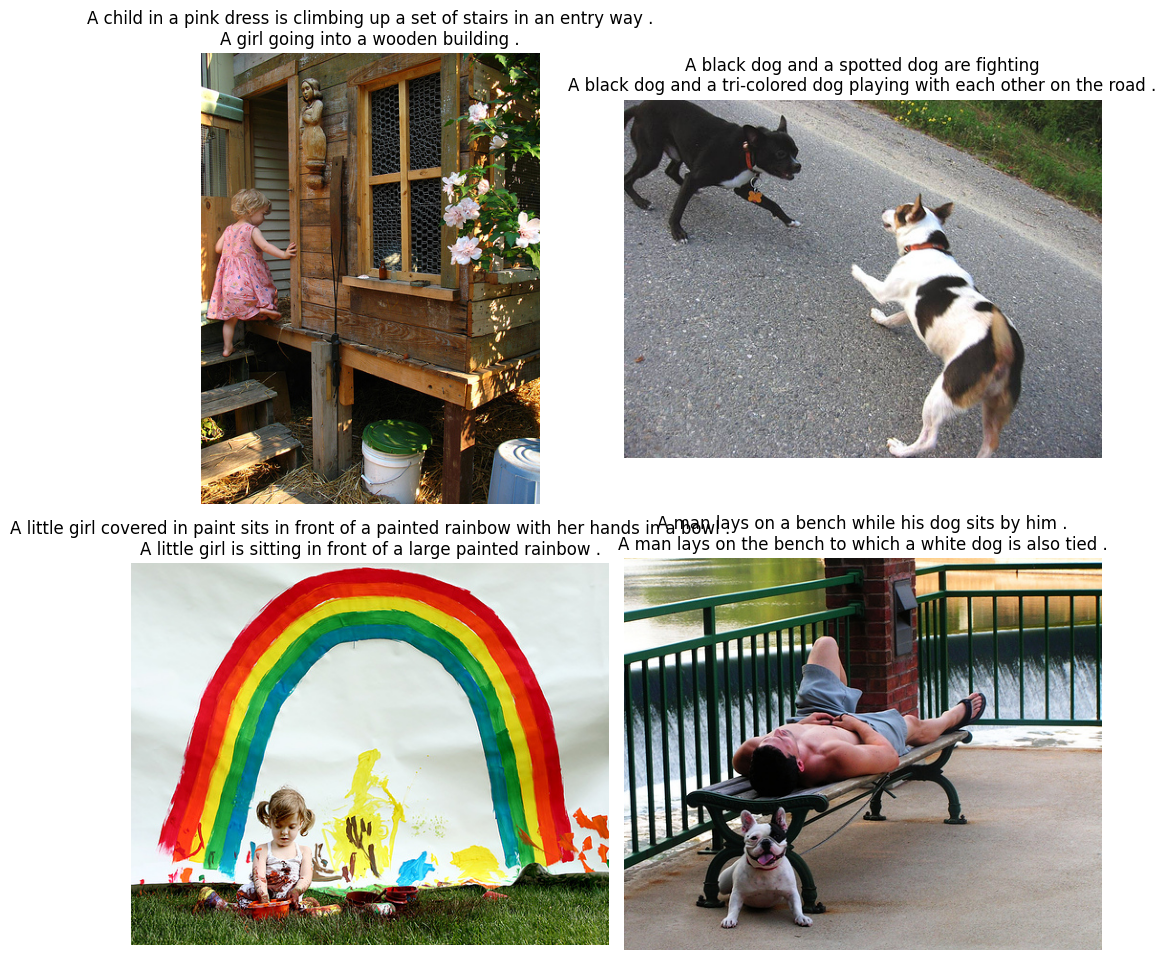

In [4]:
# Visualize sample images with their captions
def visualize_images(image_dir, caption_dict, num_images=4):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        image_id = list(caption_dict.keys())[i]
        image_path = os.path.join(image_dir, image_id)
        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title('\n'.join(caption_dict[image_id][:2]))  # Show the first two captions for each image
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample images with their captions
visualize_images(image_dir, caption_dict)


In [5]:
# Clean captions
def clean_caption(caption):
    caption = caption.lower()
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    return caption

# Clean all captions
cleaned_captions = {k: [clean_caption(c) for c in v] for k, v in caption_dict.items()}


In [6]:
# Tokenize captions
all_captions = [caption for captions in cleaned_captions.values() for caption in captions]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)

# Save tokenizer for later use
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print(f'Vocabulary size: {vocab_size}')
print(f'Max caption length: {max_length}')


Vocabulary size: 8829
Max caption length: 36


In [7]:
# Split data into train and test sets
image_ids = list(cleaned_captions.keys())
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

train_captions = {k: cleaned_captions[k] for k in train_ids}
test_captions = {k: cleaned_captions[k] for k in test_ids}


In [8]:
# Load and preprocess images with error handling for missing files
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((299, 299))
    image = np.array(image) / 255.0
    return image

# Load images into a dictionary
def load_images(image_ids, image_dir):
    images = {}
    for image_id in image_ids:
        image_path = os.path.join(image_dir, image_id)
        if os.path.exists(image_path):
            images[image_id] = preprocess_image(image_path)
        else:
            print(f"Warning: {image_path} not found, skipping.")
    return images

# Load training and testing images
train_images = load_images(train_ids, image_dir)
test_images = load_images(test_ids, image_dir)

print(f'Number of training images: {len(train_images)}')
print(f'Number of testing images: {len(test_images)}')


Number of training images: 6473
Number of testing images: 1618


In [9]:
# Create data generator
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key, desc_list in descriptions.items():
            if key not in photos:  # Skip keys with missing images
                continue
            n += 1
            photo = photos[key]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n = 0


In [10]:
# Define the image captioning model
def define_model(vocab_size, max_length):
    # Feature extractor model
    image_model = InceptionV3(include_top=False, pooling='avg')
    image_model.trainable = False
    
    # Image feature input
    inputs1 = Input(shape=(2048,))
    fe1 = Dense(256, activation='relu')(inputs1)
    
    # Sequence input
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = LSTM(256)(se1)
    
    # Decoder model
    decoder1 = Add()([fe1, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Tie it together
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Define the model
model = define_model(vocab_size, max_length)
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 44s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 36, 256)   │  2,260,224 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 36)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8829)      │  2,269,053 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,644,925 (21.53 MB)

 Trainable params: 5,644,925 (21.53 MB)

 Non-trainable params: 0 (0.00 B)